## Figures

This notebook contains code for producing the figures in the paper.

In [1]:
from typing import Optional, Tuple

import arviz as az
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from model_fit_tools.plotting import plot_waic
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import pearsonr

from transition_uncertainty.data import load_and_process_data
from transition_uncertainty.plotting import plot_summary_data
from transition_uncertainty.style import set_style
from transition_uncertainty.utils import check_directories

# Raise an error if we're not in the root directory by checking if the data folder exists
check_directories()

# Set style for figures
set_style("style.mplstyle")

# Set higher DPI for figures
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.dpi": 96})

# Get default palette
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

/scratch/users/user/miniconda3/envs/tu_test/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Font Heebo already available in Matplotlib.
Matplotlib style set to: style.mplstyle with font Heebo


## Useful functions

In [2]:
def plot_best_models(
    best_models: pd.DataFrame,
    axis: Optional[plt.Axes] = None,
    grid_shape: Tuple[int, int] = (12, 50),
) -> plt.Axes:
    """
    Plots the best fitting model for each subject in the provided DataFrame.

    Args:
        best_models (pd.DataFrame): DataFrame containing the 'model' and 
            'subject' columns.
        axis (Optional[plt.Axes], optional): Matplotlib axis to plot on.
            If None, a new figure and axis are created. Defaults to None.
        grid_shape (Tuple[int, int], optional): The size of the grid 
            to plot the models on. Defaults to (5, 4).

    Returns:
        plt.Axes: The axis with the plot.
    """
    # Create a dictionary to map models to integers
    model_to_int = {
        model: i
        for i, model in enumerate(sorted(best_models["model"].unique()))
    }

    # Map the best model for each subject to an integer
    best_models["model_int"] = best_models["model"].map(model_to_int)

    # Sort best_models by 'model_int'
    best_models = best_models.sort_values("model_int")

    # Determine the grid size
    num_subjects = best_models["subject"].nunique()

    # Initialize an array for the grid
    model_grid = np.full(
        grid_shape, -1
    )  # Fill with -1 to identify empty cells later

    # Assign each subject's best model to the grid
    for i, (_, row) in enumerate(best_models.iterrows()):
        row_idx, col_idx = divmod(i, grid_shape[1])
        model_grid[row_idx, col_idx] = row["model_int"]

    # Colours
    colors = ["#5CA5FF", "#F141D3", "#FFC547", "#87cd79"]

    # Create a ListedColormap with the default color cycle
    cmap = mcolors.ListedColormap(colors[: len(model_to_int)])

    # Plot
    if axis is None:
        fig, axis = plt.subplots(figsize=(5, 4))

    axis.imshow(model_grid, cmap=cmap)

    # Add grid lines and remove tick marks
    axis.grid(
        which="major", axis="both", linestyle="-", color="white", linewidth=1
    )
    axis.set_xticks(np.arange(-0.5, grid_shape[1], 1))
    axis.set_yticks(np.arange(-0.5, grid_shape[0], 1))
    axis.tick_params(axis="both", which="major", length=0)

    axis.set_title("Best Fitting Model for Each Subject")

    # Dictionary to rename models
    model_rename_dict = {
        "mb_only": "MB",
        "mf_only": "MF",
        "weighting": "Weighted",
        "weighting_fixed": "Fixed",
    }

    # Create invisible scatter points for the legend
    for model, color in zip(model_to_int, colors):
        axis.scatter([], [], color=color, label=model_rename_dict[model])

    # Add legend
    axis.legend(
        title="Model",
        bbox_to_anchor=(1.0, 1.1),
        loc="upper left",
        frameon=False,
    )

    # Remove axis lines
    for side in ["left", "right", "top", "bottom"]:
        axis.spines[side].set_visible(False)

    # Remove tick labels
    axis.set_xticklabels([])
    axis.set_yticklabels([])

    return axis

In [3]:
print("DISCOVERY\n-----------")
qdata_discovery = load_and_process_data("discovery", scale=False)
print("-----------\n\nREPLICATION\n-----------")
qdata_replication = load_and_process_data("replication", scale=False)
print("-----------\nRETEST\n-----------")
qdata_retest = load_and_process_data(
    "retest",
    scale=False,
    include_questionnaire=False,
    include_factor=False,
    include_confidence=False,
)
print("-----------\n\nFOLLOW=UP\n-----------")
qdata_T2 = load_and_process_data(
    "follow-up",
    scale=False,
    include_confidence=False,
)
print("-----------\n\nFOLLOW=UP-1YR\n-----------")
qdata_T3 = load_and_process_data(
    "follow-up-1yr",
    scale=False,
    include_confidence=False,
)
# Copy of discovery data for longitudinal stuff
qdata_T1 = qdata_discovery.copy()

# Load raw task data
task_data_discovery = pd.read_csv(
    "data/discovery/transition-task/cannonball_task_data.csv"
)
task_data_replication = pd.read_csv(
    "data/replication/transition-task/cannonball_task_data.csv"
)

# Load task spec
task_spec = pd.read_csv("data/task_spec/task_spec_df.csv")

# Load confidence models
confidence_results_discovery = az.from_netcdf(
    "results/discovery/confidence_model-fit/model-2.nc"
)
confidence_results_replication = az.from_netcdf(
    "results/replication/confidence_model-fit/model-2.nc"
)

# Get summmary
confidence_summary_discovery = az.summary(
    confidence_results_discovery,
    var_names=["transition_irr_uncertainty", "transition_var"],
    hdi_prob=0.95,
    kind="stats",
)

confidence_summary_replication = az.summary(
    confidence_results_replication,
    var_names=["transition_irr_uncertainty", "transition_var"],
    hdi_prob=0.95,
    kind="stats",
)

# combine with a new column for the dataset
confidence_summary_discovery["dataset"] = "discovery"
confidence_summary_replication["dataset"] = "replication"

# combine the two datasets
summary = pd.concat(
    [confidence_summary_discovery, confidence_summary_replication]
)

# Load model comparison
# Load data from the 'discovery' directory
waic_df_discovery = pd.read_csv(
    "results/discovery/transition-task_model-fit/group_waic.csv"
).iloc[:, 1:]
subject_waic_df_discovery = pd.read_csv(
    "results/discovery/transition-task_model-fit/subject_waic.csv"
).iloc[:, 1:]

# Add a column indicating the dataset
waic_df_discovery["dataset"] = "discovery"
subject_waic_df_discovery["dataset"] = "discovery"

# Load data from the 'replication' directory
waic_df_replication = pd.read_csv(
    "results/replication/transition-task_model-fit/group_waic.csv"
).iloc[:, 1:]
subject_waic_df_replication = pd.read_csv(
    "results/replication/transition-task_model-fit/subject_waic.csv"
).iloc[:, 1:]

# Add a column indicating the dataset
waic_df_replication["dataset"] = "replication"
subject_waic_df_replication["dataset"] = "replication"

# Concatenate data from both directories
waic_df = pd.concat(
    [waic_df_discovery, waic_df_replication], ignore_index=True
)
subject_waic_df = pd.concat(
    [subject_waic_df_discovery, subject_waic_df_replication], ignore_index=True
)

# Get best models
best_models = subject_waic_df.loc[
    subject_waic_df.groupby(["subject", "dataset"])["waic"].idxmax()
]
model_counts = best_models["model"].value_counts()

# Symptom analyses
transdiagnostic_results_discovery = pd.read_csv(
    "results/discovery/symptom_models/transdiagnostic_results.csv"
)
transdiagnostic_results_replication = pd.read_csv(
    "results/replication/symptom_models/transdiagnostic_results.csv"
)

# Combine with a column for the dataset
transdiagnostic_results_discovery["dataset"] = "discovery"
transdiagnostic_results_replication["dataset"] = "replication"

# Combine the two datasets
transdiagnostic_results = pd.concat(
    [transdiagnostic_results_discovery, transdiagnostic_results_replication],
    ignore_index=True,
)

anx_dep_results_discovery = pd.read_csv(
    "results/discovery/symptom_models/anx_dep_results.csv"
)
anx_dep_results_replication = pd.read_csv(
    "results/replication/symptom_models/anx_dep_results.csv"
)

# Combine with a column for the dataset
anx_dep_results_discovery["dataset"] = "discovery"
anx_dep_results_replication["dataset"] = "replication"

# Combine the two datasets
anx_dep_results_results = pd.concat(
    [anx_dep_results_discovery, anx_dep_results_replication], ignore_index=True
)

# LONGITUDINAL RESULTS
for dataset in [qdata_T1, qdata_T2, qdata_T3]:
    dataset["MB_MF_WAIC_diff_transformed"] = dataset["MB_MF_WAIC_diff"] ** 0.3

# Merge the dataframes on 'subjectID' with suffixes
combined_data = qdata_T1.merge(
    qdata_T2, on="subjectID", suffixes=("__T1", "__T2")
)
combined_data = combined_data.merge(
    qdata_T3.rename(
        columns=dict(
            zip(
                [c for c in qdata_T3.columns if c != "subjectID"],
                [
                    f"{col}__T3"
                    for col in qdata_T3.columns
                    if col != "subjectID"
                ],
            )
        )
    ),
    on="subjectID",
)

transdiagnostic_results_follow_up = pd.read_csv(
    "results/follow-up/longitudinal_symptom_models/transdiagnostic_results.csv"
)
transdiagnostic_results_follow_up_1yr = pd.read_csv(
    "results/follow-up-1yr/longitudinal_symptom_models/transdiagnostic_results.csv"
)

# Combine with a column for the dataset
transdiagnostic_results_follow_up["dataset"] = "3 months"
transdiagnostic_results_follow_up_1yr["dataset"] = "1 year"

# Combine the two datasets
transdiagnostic_results_longitudinal = pd.concat(
    [transdiagnostic_results_follow_up, transdiagnostic_results_follow_up_1yr],
    ignore_index=True,
)

anx_dep_results_follow_up = pd.read_csv(
    "results/follow-up/longitudinal_symptom_models/anx_dep_results.csv"
)
anx_dep_results_follow_up_1yr = pd.read_csv(
    "results/follow-up-1yr/longitudinal_symptom_models/anx_dep_results.csv"
)

# Combine with a column for the dataset
anx_dep_results_follow_up["dataset"] = "3 months"
anx_dep_results_follow_up_1yr["dataset"] = "1 year"

# Combine the two datasets
anx_dep_results_longitudinal = pd.concat(
    [anx_dep_results_follow_up, anx_dep_results_follow_up_1yr],
    ignore_index=True,
)

qdata_T1["time"] = "Baseline"
qdata_T2["time"] = "3 months"
qdata_T3["time"] = "1 year"

# Get score over time
score_data = pd.concat(
    [
        qdata_T1[["subjectID", "score", "time"]],
        qdata_T2[["subjectID", "score", "time"]],
        qdata_T3[["subjectID", "score", "time"]],
    ],
    ignore_index=True,
)

DISCOVERY
-----------


/scratch/users/user/transition_uncertainty/transition_uncertainty/analysis_utils.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'pink' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  confidence_df.loc[confidence_df["pinkBet"] != 0, "bet_colour"] = "pink"


Initial number of subjects: 600
Number of included subjects after excluding gender != 0 or 1: 592
Number of included subjects after excluding age < 18 or >= 100: 592
Number of included subjects after excluding attention check failures: 551
Mean (SD) age = 40.75 (12.32)
n male = 275; n female = 276
Number scoring above cutoff for GAD: 116 (21.05%)
Number scoring above cutoff for MDD: 128 (23.23%)
Number of subjects after filtering and processing: 551
-----------

REPLICATION
-----------


/scratch/users/user/transition_uncertainty/transition_uncertainty/analysis_utils.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'pink' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  confidence_df.loc[confidence_df["pinkBet"] != 0, "bet_colour"] = "pink"
/scratch/users/user/transition_uncertainty/transition_uncertainty/analysis_utils.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'pink' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  confidence_df.loc[confidence_df["pinkBet"] != 0, "bet_colour"] = "pink"


Initial number of subjects: 1400
Number of included subjects after excluding gender != 0 or 1: 1391
Number of included subjects after excluding age < 18 or >= 100: 1391
Number of included subjects after excluding attention check failures: 1322
Mean (SD) age = 41.15 (12.69)
n male = 655; n female = 667
Number scoring above cutoff for GAD: 243 (18.38%)
Number scoring above cutoff for MDD: 312 (23.6%)
Number of subjects after filtering and processing: 1322
-----------
RETEST
-----------
Initial number of subjects: 80
Number of subjects after filtering and processing: 80
-----------

FOLLOW=UP
-----------


/scratch/users/user/transition_uncertainty/transition_uncertainty/analysis_utils.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'pink' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  confidence_df.loc[confidence_df["pinkBet"] != 0, "bet_colour"] = "pink"


Initial number of subjects: 412
Number of included subjects after excluding gender != 0 or 1: 408
Number of included subjects after excluding age < 18 or >= 100: 408
Number of included subjects after excluding attention check failures: 385
Mean (SD) age = 41.80 (12.39)
n male = 198; n female = 187
Number scoring above cutoff for GAD: 60 (15.58%)
Number scoring above cutoff for MDD: 81 (21.04%)
Number of subjects after filtering and processing: 385
-----------

FOLLOW=UP-1YR
-----------


/scratch/users/user/transition_uncertainty/transition_uncertainty/analysis_utils.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'pink' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  confidence_df.loc[confidence_df["pinkBet"] != 0, "bet_colour"] = "pink"


Initial number of subjects: 344
Number of included subjects after excluding gender != 0 or 1: 343
Number of included subjects after excluding age < 18 or >= 100: 343
Number of included subjects after excluding attention check failures: 326
Mean (SD) age = 43.78 (12.22)
n male = 172; n female = 154
Number scoring above cutoff for GAD: 40 (12.27%)
Number scoring above cutoff for MDD: 58 (17.79%)
Number of subjects after filtering and processing: 326


## Figure 1

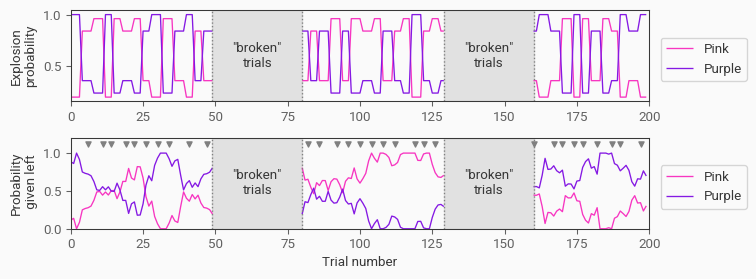

In [19]:
colours = ["#f736c1", "#8519e3"]  # pink  # purple

f, ax = plt.subplots(2, 1, figsize=(8, 3))

# Success probs
ax[0].plot(task_spec["pinkExplodeChance"], color=colours[0])
ax[0].plot(task_spec["purpleExplodeChance"], color=colours[1])

ax[0].set_ylabel("Explosion\nprobability")

# Fill areas where pinkExplodeChance/purpleExplodeChance is nan with grey
# Identifying the NaN regions
y = task_spec["pinkExplodeChance"]
x = task_spec.index

# Get current y-axis limits from the axes object
ymin, ymax = ax[0].get_ylim()

# Identifying the NaN regions
nan_regions = np.isnan(y)
start = None
for i, val in enumerate(nan_regions):
    if val and start is None:
        start = i
    elif not val and start is not None:
        ax[0].fill_between(
            x[start - 1 : i + 1], ymin, ymax, color="gray", alpha=0.2
        )
        ax[0].vlines(
            [x[start - 1], x[i]], ymin, ymax, color="gray", linestyles="dotted"
        )

        # Add text
        middle_x = x[start - 1] + (x[i] - x[start - 1]) / 2
        middle_y = (ymin + ymax) / 2
        ax[0].text(
            middle_x, middle_y, '"broken"\ntrials', ha="center", va="center"
        )

        start = None

# Check if the last region in the data is NaN and handle it
if start is not None:
    ax[0].fill_between(x[start - 1 :], ymin, ymax, color="gray", alpha=0.2)
    ax[0].vlines(x[start - 1], ymin, ymax, color="gray", linestyles="dotted")

    # Add text for the last region
    middle_x = x[start - 1] + (x[-1] - x[start - 1]) / 2
    ax[0].t

# Legend placed outside the figure to the right
ax[0].legend(
    ["Pink", "Purple"], bbox_to_anchor=(1.02, 0.7), loc=2, borderaxespad=0.0
)

# Set ylim again (not sure why this is needed)
ax[0].set_ylim([ymin, ymax])

# Set xlim
ax[0].set_xlim([0, 200])

## Plot pink/purple probs
# set to NaN if y is NaN
task_spec.loc[y.isnull(), "right_prob_purple"] = np.nan
task_spec.loc[y.isnull(), "left_prob_purple"] = np.nan

ax[1].plot(
    task_spec["right_prob_purple"], color=colours[0], label="Pink"
)  # equal to left prob pink
ax[1].plot(task_spec["left_prob_purple"], color=colours[1], label="Purple")

# Set ylabel
ax[1].set_ylabel("Probability\n given left")

# Set xlim
ax[1].set_xlim([0, 200])

# Set ylim
ax[1].set_ylim([0, 1.2])

# Legend
ax[1].legend(
    ["Pink", "Purple"], bbox_to_anchor=(1.02, 0.7), loc=2, borderaxespad=0.0
)

# Get indices where confidence_trial is 1
confidence_indices = task_spec[task_spec["confidence_trial"] == 1].index
confidence_values = task_spec.loc[confidence_indices, "left_prob_purple"]

# Add down-facing triangles at these points
# Assuming you want the triangle to appear at the top of the plot
ymax = ax[1].get_ylim()[1]
ax[1].scatter(
    confidence_indices,
    [ymax * 0.93] * len(confidence_indices),
    marker="v",
    color="gray",
    s=15,
)

# Set x label
ax[1].set_xlabel("Trial number")

# Broken trials
y = task_spec["pinkExplodeChance"]
x = task_spec.index

# Get current y-axis limits from the axes object
ymin, ymax = ax[1].get_ylim()

# Identifying the NaN regions
nan_regions = np.isnan(y)
start = None
for i, val in enumerate(nan_regions):
    if val and start is None:
        start = i
    elif not val and start is not None:
        ax[1].fill_between(
            x[start - 1 : i + 1], ymin, ymax, color="gray", alpha=0.2
        )
        ax[1].vlines(
            [x[start - 1], x[i]], ymin, ymax, color="gray", linestyles="dotted"
        )

        # Add text
        middle_x = x[start - 1] + (x[i] - x[start - 1]) / 2
        middle_y = (ymin + ymax) / 2
        ax[1].text(
            middle_x, middle_y, '"broken"\ntrials', ha="center", va="center"
        )

        start = None

plt.tight_layout()

# Save
plt.savefig("figures/task_spec.svg", bbox_inches="tight")

## Figure 2

/tmp/ipykernel_3036702/3970135402.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


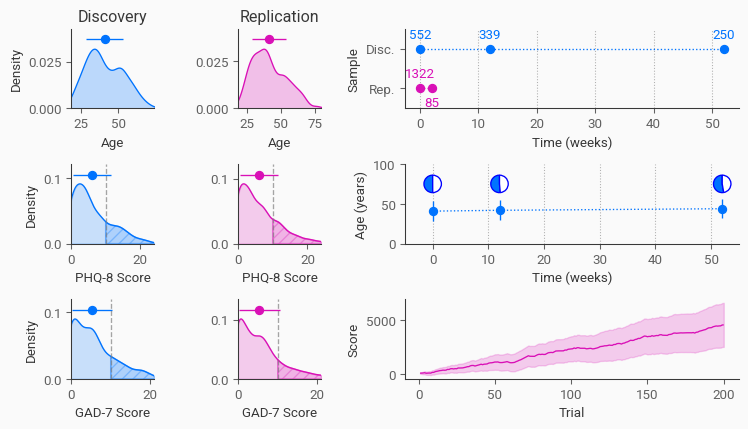

In [10]:
import numpy as np

# get matplotlib color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig = plt.figure(figsize=(8, 4.5))

# create gridspec
gs = fig.add_gridspec(
    3,
    3,
    height_ratios=[1, 1, 1],
    width_ratios=[1, 1, 4],
    wspace=0.5,
    hspace=0.7,
)

# add axes
# Initialize an array to hold the axes
ax = np.empty((3, 3), dtype=object)

# Create axes in the gridspec and store them in the array
for row in range(3):
    for col in range(3):
        ax[row, col] = fig.add_subplot(gs[row, col])
# AGE

sns.kdeplot(qdata_discovery["age"], fill=True, clip=[18, 100], ax=ax[0, 0])
sns.kdeplot(
    qdata_replication["age"],
    fill=True,
    clip=[18, 100],
    ax=ax[0, 1],
    color=colours[1],
)

# set x axis labels
ax[0, 0].set_xlabel("Age")
ax[0, 1].set_xlabel("Age")

ax[0, 1].set_ylabel("")

ax[0, 0].set_xlim(18, qdata_discovery["age"].max())
ax[0, 1].set_xlim(18, qdata_replication["age"].max())

# Add a scatter + errorbar to each ax with the mean +/- std of age
mean_age_discovery = qdata_discovery["age"].mean()
std_age_discovery = qdata_discovery["age"].std()
mean_age_replication = qdata_replication["age"].mean()
std_age_replication = qdata_replication["age"].std()

# Get highest value in the kdeplot
y_max_discovery = ax[0, 0].get_ylim()[1]
y_max_replication = ax[0, 1].get_ylim()[1]

ax[0, 0].errorbar(
    mean_age_discovery,
    y_max_discovery + (y_max_discovery * 0.1),
    xerr=std_age_discovery,
    fmt="o",
    color=colours[0],
)
ax[0, 1].errorbar(
    mean_age_replication,
    y_max_replication + (y_max_replication * 0.1),
    xerr=std_age_replication,
    fmt="o",
    color=colours[1],
)

# Add titles
ax[0, 0].set_title("Discovery")
ax[0, 1].set_title("Replication")

# SYMPTOMS

sns.kdeplot(
    qdata_discovery["PHQ_8"],
    clip=(0, qdata_replication["PHQ_8"].max()),
    ax=ax[1, 0],
    color=colors[0],
)
ax[1, 0].set_xlabel("PHQ-8 Score")
ax[1, 0].set_ylabel("Density")
ax[1, 0].set_xlim(0, qdata_replication["PHQ_8"].max())
ax[1, 0].errorbar(
    qdata_replication["PHQ_8"].mean(),
    ax[1, 0].get_ylim()[1] + (ax[1, 0].get_ylim()[1] * 0.1),
    xerr=qdata_replication["PHQ_8"].std(),
    fmt="o",
    color=colours[0],
)

sns.kdeplot(
    qdata_replication["PHQ_8"],
    clip=(0, qdata_replication["PHQ_8"].max()),
    ax=ax[1, 1],
    color=colors[1],
)
ax[1, 1].set_xlabel("PHQ-8 Score")
ax[1, 1].set_ylabel("")
ax[1, 1].set_xlim(0, qdata_replication["PHQ_8"].max())
ax[1, 1].errorbar(
    qdata_replication["PHQ_8"].mean(),
    ax[1, 1].get_ylim()[1] + (ax[1, 1].get_ylim()[1] * 0.1),
    xerr=qdata_replication["PHQ_8"].std(),
    fmt="o",
    color=colours[1],
)


sns.kdeplot(
    qdata_discovery["GAD_7"],
    clip=(0, qdata_replication["GAD_7"].max()),
    ax=ax[2, 0],
    color=colors[0],
)
ax[2, 0].set_xlabel("GAD-7 Score")
ax[2, 0].set_ylabel("Density")
ax[2, 0].set_xlim(0, qdata_replication["GAD_7"].max())
ax[2, 0].errorbar(
    qdata_replication["GAD_7"].mean(),
    ax[2, 0].get_ylim()[1] + (ax[2, 0].get_ylim()[1] * 0.1),
    xerr=qdata_replication["GAD_7"].std(),
    fmt="o",
    color=colours[0],
)

sns.kdeplot(
    qdata_replication["GAD_7"],
    clip=(0, qdata_replication["GAD_7"].max()),
    ax=ax[2, 1],
    color=colors[1],
)
ax[2, 1].set_xlabel("GAD-7 Score")
ax[2, 1].set_ylabel("")
ax[2, 1].set_xlim(0, qdata_replication["GAD_7"].max())
ax[2, 1].errorbar(
    qdata_replication["GAD_7"].mean(),
    ax[2, 1].get_ylim()[1] + (ax[2, 1].get_ylim()[1] * 0.1),
    xerr=qdata_replication["GAD_7"].std(),
    fmt="o",
    color=colours[1],
)

# Add dashed line at x=10 (cutoff) for each plot
for i in range(1, 3):
    for j in range(2):
        ax[i, j].axvline(10, linestyle="--", color="gray", alpha=0.7)

# Fill the area to the right of the vertical line
for i in range(1, 3):
    for j in range(2):
        kde_line = ax[i, j].get_lines()[0]
        x = np.array(kde_line.get_xdata())
        y = np.array(kde_line.get_ydata())
        ax[i, j].fill_between(x, y, where=(x < 10), color=colors[j], alpha=0.2)
        ax[i, j].fill_between(
            x, y, where=(x >= 10), color=colors[j], alpha=0.3
        )
        ax[i, j].fill_between(
            x,
            y,
            where=(x >= 10),
            facecolor="none",
            edgecolor=colors[j],
            alpha=0.3,
            hatch="///",
        )

# Increase the upper y limit of every subplot by 10%
for i in range(3):
    for j in range(2):
        ax[i, j].set_ylim(
            0, ax[i, j].get_ylim()[1] + (ax[i, j].get_ylim()[1] * 0.1)
        )

sns.despine()

# timepoints

# Data samples
discovery_weeks = [0, 12, 52]
discovery_labels = [552, 339, 250]

replication_weeks = [0, 2]
replication_labels = [1322, 85]

# Get default color cycle
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Plot Discovery data
ax[0, 2].plot(
    discovery_weeks,
    [2] * len(discovery_weeks),
    marker="o",
    linestyle=":",
    label="Discovery",
)
for i, label in enumerate(discovery_labels):
    ax[0, 2].text(
        discovery_weeks[i],
        2.2,
        str(label),
        ha="center",
        va="bottom",
        color=colours[0],
    )

# Plot Replication data
ax[0, 2].plot(
    replication_weeks,
    [1] * len(replication_weeks),
    marker="o",
    linestyle=":",
    label="Replication",
)
for i, label in enumerate(replication_labels):
    if i == 0:
        ax[0, 2].text(
            replication_weeks[i],
            1.2,
            str(label),
            ha="center",
            va="bottom",
            color=colours[1],
        )
    else:
        # put it below
        ax[0, 2].text(
            replication_weeks[i],
            0.8,
            str(label),
            ha="center",
            va="top",
            color=colours[1],
        )

# Customize the plot
ax[0, 2].set_yticks([1, 2])
ax[0, 2].set_yticklabels(["Rep.", "Disc."])
ax[0, 2].set_xlabel("Time (weeks)")
ax[0, 2].set_ylabel("Sample")
# ax.legend()
ax[0, 2].grid(True, linestyle=":", axis="x")
ax[0, 2].set_ylim(0.5, 2.5)

sns.despine()

# demographics across timepoints

# Compute mean and standard deviation for the 'age' column in each dataframe
mean_age_discovery = qdata_discovery["age"].mean()
std_age_discovery = qdata_discovery["age"].std()

mean_age_follow_up = qdata_T2["age"].mean()
std_age_follow_up = qdata_T2["age"].std()

mean_age_follow_up_1yr = qdata_T3["age"].mean()
std_age_follow_up_1yr = qdata_T3["age"].std()

# X-axis values
x_values = [0, 12, 52]

# Mean ages
mean_ages = [mean_age_discovery, mean_age_follow_up, mean_age_follow_up_1yr]

# Standard deviations
std_ages = [std_age_discovery, std_age_follow_up, std_age_follow_up_1yr]

# Gender proportions
gender_discovery = qdata_discovery["gender"].value_counts(normalize=True)
gender_follow_up = qdata_T2["gender"].value_counts(normalize=True)
gender_follow_up_1yr = qdata_T3["gender"].value_counts(normalize=True)

# Plot scatter points with error bars
ax[1, 2].errorbar(
    x_values,
    mean_ages,
    yerr=std_ages,
    fmt="o",
    capsize=0,
    capthick=2,
    label="Mean Age with SD",
)

# Plot line joining the points
ax[1, 2].plot(x_values, mean_ages, color=colours[0], linestyle=":")


# Function to add pie charts
def add_pie(ax, sizes, center):
    inset = inset_axes(
        ax,
        width=0.2,
        height=0.2,
        loc="center",
        bbox_to_anchor=(center[0], center[1]),
        bbox_transform=ax.transData,
    )
    wedges, _ = inset.pie(
        sizes,
        radius=4,
        center=center,
        colors=[colours[0], "white"],
        wedgeprops=dict(edgecolor="b"),
        frame=True,
        startangle=90,
    )
    # hide inset axes
    inset.axis("off")
    return wedges


# Add pie charts for gender proportions
add_pie(ax[1, 2], gender_discovery, (0, 75))
add_pie(ax[1, 2], gender_follow_up, (12, 75))
add_pie(ax[1, 2], gender_follow_up_1yr, (52, 75))

# # Customize the plot
ax[1, 2].set_xlabel("Weeks")
ax[1, 2].set_ylabel("Age (years)")

# ax.legend()
ax[1, 2].set_ylim(0, 100)
ax[1, 2].set_xticks(
    range(0, max(x_values) + 10, 10)
)  # Set x-axis ticks every 10 units
ax[1, 2].set_xticklabels(range(0, max(x_values) + 10, 10))
ax[1, 2].grid(True, linestyle=":", axis="x")
ax[1, 2].set_xlabel("Time (weeks)")

ax[1, 2].set_xlim(-5, 55)

# score over trials
# Compute mean and standard deviation for each trial in both dataframes
grouped_replication = (
    task_data_replication.groupby(["trial"])
    .agg({"score": ["mean", "std"]})
    .reset_index()
)
grouped_replication.columns = ["trial", "mean_score", "std_score"]

# Plot Replication data
ax[2, 2].plot(
    grouped_replication["trial"],
    grouped_replication["mean_score"],
    label="Replication Mean Score",
    color=colours[1],
)
ax[2, 2].fill_between(
    grouped_replication["trial"],
    grouped_replication["mean_score"] - grouped_replication["std_score"],
    grouped_replication["mean_score"] + grouped_replication["std_score"],
    color=colours[1],
    alpha=0.2,
    label="Replication 1 SD",
)

# Customize the plot
ax[2, 2].set_xlabel("Trial")
ax[2, 2].set_ylabel("Score")
sns.despine(ax=ax[2, 2])


plt.tight_layout()

# save, making sure everything is within the figure
plt.savefig("figures/fig2.svg", bbox_inches="tight")
plt.savefig("figures/fig2.pdf", bbox_inches="tight")

## Figure 3

/tmp/ipykernel_3036702/3420764861.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_models['model_int'] = best_models['model'].map(model_to_int)
/tmp/ipykernel_3036702/3420764861.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_models['model_int'] = best_models['model'].map(model_to_int)


Discovery: r=0.20, p=0.00
Replication: r=0.25, p=0.00


/tmp/ipykernel_3036702/4263069841.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


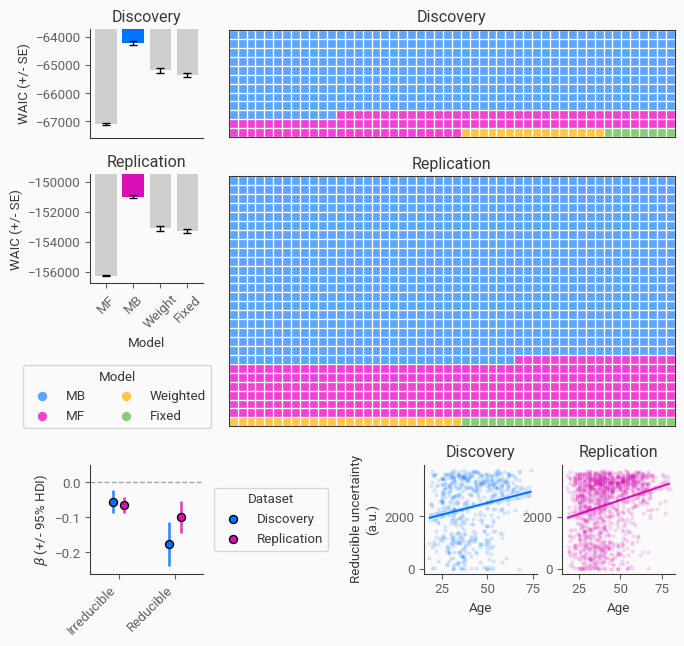

In [16]:
# get matplotlib color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig = plt.figure(figsize=(7, 7))

# create gridspec
gs = fig.add_gridspec(
    8,
    4,
    height_ratios=[1, 1, 1, 1, 1, 1, 1, 1],
    width_ratios=[1, 1.5, 1, 1],
    hspace=1,
)

ax0_1 = fig.add_subplot(gs[0:2, 0])
ax0_2 = fig.add_subplot(gs[2:4, 0])
ax0_3 = fig.add_subplot(gs[6:8, 0])

ax1 = plt.subplot(gs[0:2, 1:])
ax2 = plt.subplot(gs[2:6, 1:])

ax3 = plt.subplot(gs[6:, 2])
ax4 = plt.subplot(gs[6:, 3])


plot_waic(
    waic_df[waic_df["dataset"] == "discovery"].replace(
        {"weighting": "Weight", "weighting_fixed": "Fixed"}
    ),
    1,
    rotate_xticks=True,
    bar_kwargs={"edgecolor": "black", "linewidth": 0, "capsize": 3},
    ax=ax0_1,
    colours=["#cfcfcf", colors[0], "#cfcfcf", "#cfcfcf"],
)

plot_waic(
    waic_df[waic_df["dataset"] == "replication"].replace(
        {
            "weighting": "Weight",
            "weighting_fixed": "Fixed",
            "mb_only": "MB",
            "mf_only": "MF",
        }
    ),
    1,
    rotate_xticks=True,
    bar_kwargs={"edgecolor": "black", "linewidth": 0, "capsize": 3},
    ylim_kwargs={"top": -149500},
    ax=ax0_2,
    colours=["#cfcfcf", colors[1], "#cfcfcf", "#cfcfcf"],
)

# Remove X labels and ticks from ax[0]
ax0_1.set_xticks([])
ax0_1.set_xticklabels([])
ax0_1.set_xlabel("")

# Set subtitles for each plot
ax0_1.set_title("Discovery")
ax0_2.set_title("Replication")

# Set Y labels
ax0_1.set_ylabel("WAIC (+/- SE)")
ax0_2.set_ylabel("WAIC (+/- SE)")


# CONFIDENCE

var_names = ["transition_irr_uncertainty", "transition_var"]
datasets = ["discovery", "replication"]
titles = ["Irreducible", "Reducible"]

# Get default colour palette from matplotlib
palette = plt.rcParams["axes.prop_cycle"].by_key()["color"]

colours = [palette[0]] * len(var_names)


# Plotting points with error bars for each variable
for i, v in enumerate(var_names):

    for j, dataset in enumerate(datasets):
        # Extracting the point estimate and the HDI
        mean = summary.loc[
            (summary["dataset"] == dataset) & (summary.index == v), "mean"
        ].values[0]
        hdi_low = summary.loc[
            (summary["dataset"] == dataset) & (summary.index == v), "hdi_2.5%"
        ].values[0]
        hdi_high = summary.loc[
            (summary["dataset"] == dataset) & (summary.index == v), "hdi_97.5%"
        ].values[0]

        # Flip sign of these if v == transition_irr_uncertainty
        if v == "transition_irr_uncertainty":
            mean = -mean
            hdi_low = -hdi_low
            hdi_high = -hdi_high
        # !!!!!!!!!!!!!!!!!!!!!

        # Get colour
        if np.sign(hdi_low) == np.sign(hdi_high):
            colours[i] = palette[1]

        # Set spacing of points for each dataset
        spacing = 0.1

        # Get colour for dataset
        if dataset == "discovery":
            colours[i] = palette[0]
        else:
            colours[i] = palette[1]

        # Plotting the point estimate
        if i == 0:
            label = dataset.capitalize()
        else:
            label = None

        ax0_3.scatter(
            i + (2 * j - 1) * spacing,
            mean,
            color=colours[i],
            edgecolors="black",
            linewidths=1,
            label=label,
        )

        # Plotting the error bars (credible interval)
        ax0_3.errorbar(
            x=[i + (2 * j - 1) * spacing, i + (2 * j - 1) * spacing],
            y=[hdi_low, hdi_high],
            color=colours[i],
            capsize=0,
            capthick=2,
            linewidth=2,
            ecolor=colours[i],
            zorder=-1,
            alpha=0.8,
        )


# Add legend with dataset as title to the right of the figure
ax0_3.legend(
    title="Dataset", bbox_to_anchor=(1.6, 0.5), loc="center", frameon=True
)

# Adjust x-axis limits
ax0_3.set_xlim(-0.5, 1.5)

# Adjust y-axis limits
ax0_3.set_ylim(-0.26, 0.05)

# Setting the x-axis to show the variable titles
ax0_3.set_xticks(np.arange(len(var_names)))

# Replace spaces with newlines in titles
titles = [title.replace(" ", "\n").capitalize() for title in titles]
ax0_3.set_xticklabels(titles, rotation=45, ha="right")

ax0_3.set_ylabel(r"$\beta$" + " (+/- 95% HDI)")
ax0_3.axhline(
    0, color="grey", linestyle="--", alpha=0.7
)  # Add a horizontal line at zero for reference

sns.despine()

# SUBJECT BEST MODELS

plot_best_models(best_models[best_models["dataset"] == "discovery"], axis=ax1)
plot_best_models(
    best_models[best_models["dataset"] == "replication"],
    axis=ax2,
    grid_shape=(28, 50),
)

# Change subtitles to refer to datasets
ax1.set_title("Discovery")
ax2.set_title("Replication")

# Adding a single legend
# fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.8, 0.5))
ax2.legend(loc="center", bbox_to_anchor=(-0.25, 0.12), ncols=2, title="Model")

# Hide the original legends
ax1.get_legend().remove()
# ax2.get_legend().remove()


# AGE EFFECT

sns.regplot(
    data=qdata_discovery,
    x="age",
    y="transition_var",
    ax=ax3,
    scatter_kws={"s": 5, "alpha": 0.1},
)
ax3.set_title("Discovery")

sns.regplot(
    data=qdata_replication,
    x="age",
    y="transition_var",
    ax=ax4,
    scatter_kws={"s": 5, "alpha": 0.1},
    color=colors[1],
)
ax4.set_title("Replication")

# Print Pearson correlations
r_discovery, p_discovery = pearsonr(
    qdata_discovery["age"], qdata_discovery["transition_var"]
)
r_replication, p_replication = pearsonr(
    qdata_replication["age"], qdata_replication["transition_var"]
)

print(f"Discovery: r={r_discovery:.2f}, p={p_discovery:.2f}")
print(f"Replication: r={r_replication:.2f}, p={p_replication:.2f}")


# Relabel axes
ax3.set_xlabel("Age")
ax3.set_ylabel("Reducible uncertainty\n(a.u.)")

ax4.set_xlabel("Age")
ax4.set_ylabel("")

sns.despine()

plt.tight_layout()

# put all spines back for ax1 and ax2
ax1.spines["top"].set_visible(True)
ax1.spines["right"].set_visible(True)
ax2.spines["top"].set_visible(True)
ax2.spines["right"].set_visible(True)

# Save
# plt.savefig("figures/fig3.svg", bbox_inches="tight")
# plt.savefig("figures/fig3.pdf", bbox_inches="tight")

## Figure 4

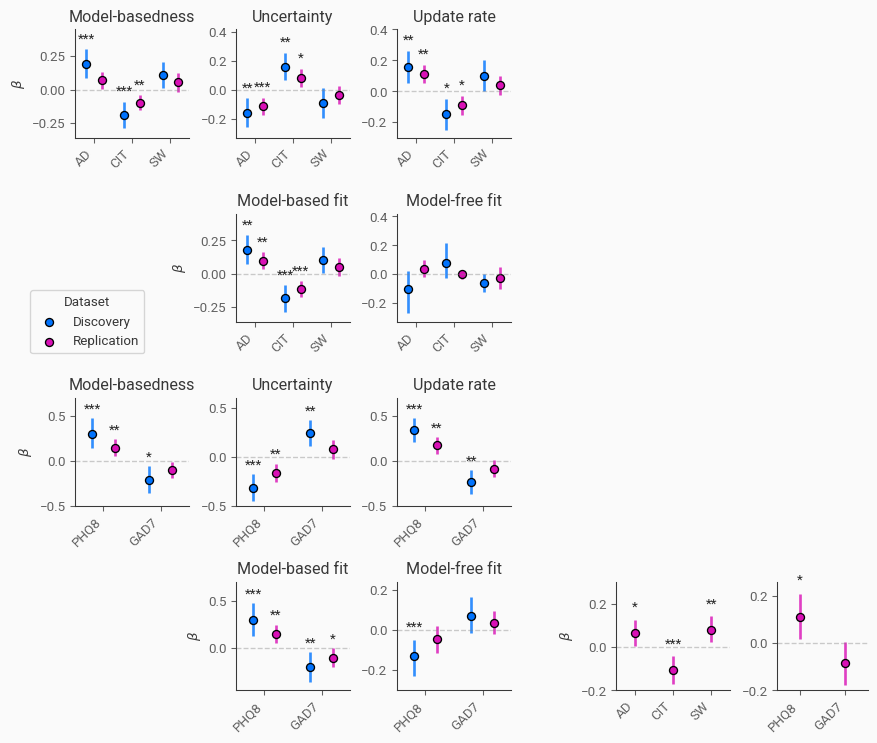

In [5]:
# create gridspec
fig = plt.figure(figsize=(9.5, 8.5))

gs = fig.add_gridspec(
    4,
    6,
    height_ratios=[1, 1, 1, 1],
    width_ratios=[1, 1, 1, 0.1, 1, 0.8],
    hspace=0.7,
    wspace=0.5,
)

# create axes
ax1_0 = fig.add_subplot(gs[0, 0])
ax1_1 = fig.add_subplot(gs[0, 1])
ax1_2 = fig.add_subplot(gs[0, 2])
# ax1_3 = fig.add_subplot(gs[0, 3])

var_names = ["AD", "Compul", "SW"]
target_var = "MB_MF_WAIC_diff"
datasets = ["discovery", "replication"]
x_labels = ["AD", "CIT", "SW"]

plot_summary_data(
    transdiagnostic_results,
    var_names,
    "MB_MF_WAIC_diff",
    datasets,
    x_labels,
    ax1_0,
    star_y_offset=0.03,
    title="Model-basedness",
    ylim=(-0.36, 0.45),
)

plot_summary_data(
    transdiagnostic_results,
    var_names,
    "transition_var",
    datasets,
    x_labels,
    ax1_1,
    star_y_offset=0.03,
    ylabel="",
    title="Uncertainty",
    ylim=(-0.33, 0.42),
)

plot_summary_data(
    transdiagnostic_results,
    var_names,
    "tau_prob",
    datasets,
    x_labels,
    ax1_2,
    star_y_offset=0.03,
    ylabel="",
    title="Update rate",
    ylim=(-0.3, 0.4),
)


# ax2_0 = fig.add_subplot(gs[1, 0])
ax2_1 = fig.add_subplot(gs[1, 1])
ax2_2 = fig.add_subplot(gs[1, 2])
# ax2_3 = fig.add_subplot(gs[1, 3])

var_names = ["AD", "Compul", "SW"]
datasets = ["discovery", "replication"]
x_labels = ["AD", "CIT", "SW"]

plot_summary_data(
    transdiagnostic_results,
    var_names,
    "MB_WAIC",
    datasets,
    x_labels,
    ax2_1,
    star_y_offset=0.03,
    title="Model-based fit",
    ylim=(-0.36, 0.45),
    significance_thresholds={
        0.001 / 5: "***",
        0.01 / 5: "**",
        0.05 / 5: "*",
    },
)

plot_summary_data(
    transdiagnostic_results,
    var_names,
    "MF_WAIC",
    datasets,
    x_labels,
    ax2_2,
    star_y_offset=0.03,
    ylabel="",
    title="Model-free fit",
    ylim=(-0.33, 0.42),
    significance_thresholds={
        0.001 / 5: "***",
        0.01 / 5: "**",
        0.05 / 5: "*",
    },
)

ax3_0 = fig.add_subplot(gs[2, 0])
ax3_1 = fig.add_subplot(gs[2, 1])
ax3_2 = fig.add_subplot(gs[2, 2])

var_names = ["PHQ_8", "GAD_7"]
datasets = ["discovery", "replication"]
x_labels = ["PHQ8", "GAD7"]

plot_summary_data(
    anx_dep_results_results,
    var_names,
    "MB_MF_WAIC_diff",
    datasets,
    x_labels,
    ax3_0,
    star_y_offset=0.03,
    title="Model-basedness",
    ylim=(-0.5, 0.7),
    significance_thresholds={
        0.001 / 3: "***",
        0.01 / 3: "**",
        0.05 / 3: "*",
    },
)

plot_summary_data(
    anx_dep_results_results,
    var_names,
    "transition_var",
    datasets,
    x_labels,
    ax3_1,
    star_y_offset=0.03,
    ylabel="",
    title="Uncertainty",
    ylim=(-0.5, 0.6),
    significance_thresholds={
        0.001 / 3: "***",
        0.01 / 3: "**",
        0.05 / 3: "*",
    },
)

plot_summary_data(
    anx_dep_results_results,
    var_names,
    "tau_prob",
    datasets,
    x_labels,
    ax3_2,
    star_y_offset=0.03,
    ylabel="",
    title="Update rate",
    ylim=(-0.5, 0.7),
    significance_thresholds={
        0.001 / 3: "***",
        0.01 / 3: "**",
        0.05 / 3: "*",
    },
)

# ax4_0 = fig.add_subplot(gs[3, 0])
ax4_1 = fig.add_subplot(gs[3, 1])
ax4_2 = fig.add_subplot(gs[3, 2])

var_names = ["PHQ_8", "GAD_7"]
datasets = ["discovery", "replication"]
x_labels = ["PHQ8", "GAD7"]

plot_summary_data(
    anx_dep_results_results,
    var_names,
    "MB_WAIC",
    datasets,
    x_labels,
    ax4_1,
    star_y_offset=0.03,
    title="Model-based fit",
    ylim=(-0.45, 0.7),
    significance_thresholds={
        0.001 / 1: "***",
        0.01 / 1: "**",
        0.05 / 1: "*",
    },
)

plot_summary_data(
    anx_dep_results_results,
    var_names,
    "MF_WAIC",
    datasets,
    x_labels,
    ax4_2,
    star_y_offset=0.03,
    ylabel="",
    title="Model-free fit",
    ylim=(-0.3, 0.24),
    significance_thresholds={
        0.001 / 1: "***",
        0.01 / 1: "**",
        0.05 / 1: "*",
    },
)


# Add legend outside to the right
# ax2_3 = fig.add_subplot(gs[1, 3])

ax2_1.legend(
    title="Dataset", bbox_to_anchor=(-1.3, 0), loc="center", frameon=True
)
# ax4_1.legend(title="Dataset", bbox_to_anchor=(-1.3, 0), loc="center", frameon=True)

# plt.tight_layout()

ax5_0 = fig.add_subplot(gs[3, 4])
ax5_1 = fig.add_subplot(gs[3, 5])

var_names = ["PHQ_8", "GAD_7"]
datasets = ["replication"]

colours = plt.rcParams["axes.prop_cycle"].by_key()["color"][1]
colours = [colours, colours]

plot_summary_data(
    transdiagnostic_results,
    ["AD", "Compul", "SW"],
    "two_step_parameter",
    datasets,
    ["AD", "CIT", "SW"],
    ax5_0,
    star_y_offset=0.03,
    # title="Model-based fit",
    ylim=(-0.2, 0.3),
    significance_thresholds={
        0.001 / 1: "***",
        0.01 / 1: "**",
        0.05 / 1: "*",
    },
    palette=colours,
)

plot_summary_data(
    anx_dep_results_results,
    ["PHQ_8", "GAD_7"],
    "two_step_parameter",
    datasets,
    ["PHQ8", "GAD7"],
    ax5_1,
    star_y_offset=0.03,
    ylabel="",
    # title="Model-free fit",
    ylim=(-0.2, 0.26),
    significance_thresholds={
        0.001 / 1: "***",
        0.01 / 1: "**",
        0.05 / 1: "*",
    },
    palette=colours,
)

# Save
plt.savefig("figures/fig4.svg")

## Figure 5

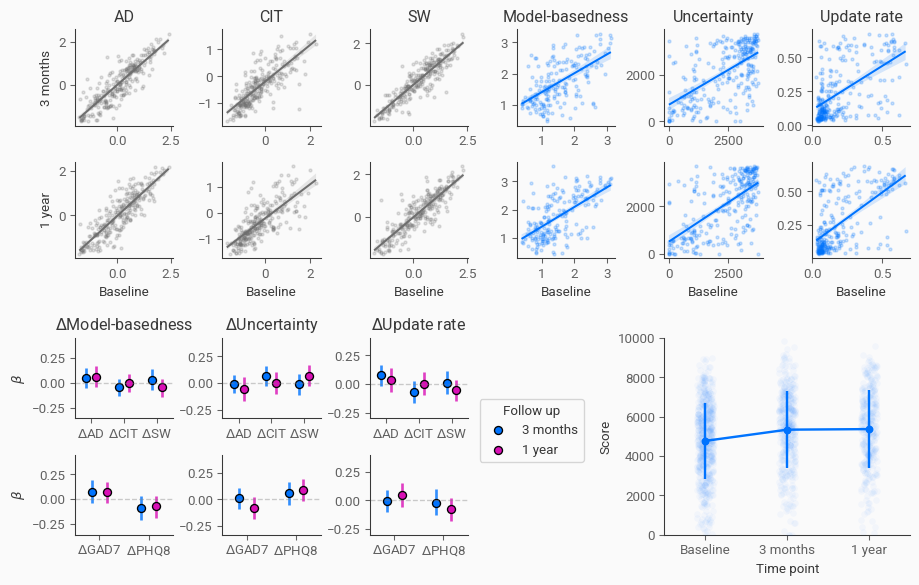

In [12]:
fig = plt.figure(figsize=(10, 6.5))

palette = colours

# create gridspec
gs = fig.add_gridspec(
    5, 6, height_ratios=[1.2, 1.2, 0.1, 1, 1], width_ratios=[1, 1, 1, 1, 1, 1]
)

# add axes
# Initialize an array to hold the axes
ax = np.empty((5, 6), dtype=object)

# Create axes in the gridspec and store them in the array
for row in range(5):
    for col in range(6):
        ax[row, col] = fig.add_subplot(gs[row, col])


ax1 = plt.subplot(gs[3:5, 4:])
# hide the other axes
for i in range(2, 5):
    for j in range(3, 6):
        ax[i, j].axis("off")

ax[2, 0].axis("off")
ax[2, 1].axis("off")
ax[2, 2].axis("off")

# factors

measures = ["AD", "Compul", "SW"]
titles = ["AD", "CIT", "SW"]

for n, m in enumerate(measures):
    sns.regplot(
        data=combined_data,
        x=f"{m}__T1",
        y=f"{m}__T2",
        ax=ax[0, measures.index(m)],
        scatter_kws={"s": 5, "alpha": 0.2},
        color="#6e6e6e",
    )
    sns.regplot(
        data=combined_data,
        x=f"{m}__T1",
        y=f"{m}__T3",
        ax=ax[1, measures.index(m)],
        scatter_kws={"s": 5, "alpha": 0.2},
        color="#6e6e6e",
    )

# Dictionary for the labels
timepoints = {"T2": "3 months", "T3": "1 year"}

# Update axis labels
for i in range(2):
    for j in range(len(measures)):
        ax[i, j].set_xlabel(f"Baseline")
        ax[i, j].set_ylabel(timepoints[f"T{2+i}"])
        if j > 0:
            ax[i, j].set_ylabel("")
        if i == 0:
            ax[i, j].set_title(titles[j])
            ax[i, j].set_xlabel("")

sns.despine()

# PARAMETERS

measures = ["MB_MF_WAIC_diff_transformed", "transition_var", "tau_prob"]

titles = ["Model-basedness", "Uncertainty", "Update rate"]


for n, m in enumerate(measures):
    sns.regplot(
        data=combined_data,
        x=f"{m}__T1",
        y=f"{m}__T2",
        ax=ax[0, measures.index(m) + 3],
        scatter_kws={"s": 5, "alpha": 0.2},
        color=palette[0],
    )
    sns.regplot(
        data=combined_data,
        x=f"{m}__T1",
        y=f"{m}__T3",
        ax=ax[1, measures.index(m) + 3],
        scatter_kws={"s": 5, "alpha": 0.2},
        color=palette[0],
    )

# Update axis labels
for i in range(2):
    for j in range(3, 3 + len(measures)):
        ax[i, j].set_xlabel(f"Baseline")
        ax[i, j].set_ylabel(timepoints[f"T{2+i}"])
        if j > 0:
            ax[i, j].set_ylabel("")
        if i == 0:
            ax[i, j].set_title(titles[j - 3])
            ax[i, j].set_xlabel("")

sns.despine()

# TRANSDIAGNOSTIC MODELS

var_names = ["AD__change", "Compul__change", "SW__change"]
target_var = "MB_MF_WAIC_diff"
datasets = ["3 months", "1 year"]
x_labels = [
    r"$\Delta$" + "AD",
    r"$\Delta$" + "CIT",
    r"$\Delta$" + "SW",
]

titles = [
    r"$\Delta$" + "Model\nbasedness",
    r"$\Delta$" + "Transition\nuncertainty",
    r"$\Delta$" + "Transition\nupdate rate",
]

plot_summary_data(
    transdiagnostic_results_longitudinal,
    var_names,
    "MB_MF_WAIC_diff__change",
    datasets,
    x_labels,
    ax[3, 0],
    star_y_offset=0.03,
    title=r"$\Delta$" + "Model-basedness",
    ylim=(-0.36, 0.45),
    spacing=0.15,
)

plot_summary_data(
    transdiagnostic_results_longitudinal,
    var_names,
    "transition_var__change",
    datasets,
    x_labels,
    ax[3, 1],
    star_y_offset=0.03,
    ylabel="",
    title=r"$\Delta$" + "Uncertainty",
    ylim=(-0.33, 0.42),
    spacing=0.15,
)

plot_summary_data(
    transdiagnostic_results_longitudinal,
    var_names,
    "tau_prob__change",
    datasets,
    x_labels,
    ax[3, 2],
    star_y_offset=0.03,
    ylabel="",
    title=r"$\Delta$" + "Update rate",
    ylim=(-0.3, 0.4),
    spacing=0.15,
)

# unrotate the x-axis labels
ax[3, 0].set_xticklabels(ax[3, 0].get_xticklabels(), rotation=0, ha="center")
ax[3, 1].set_xticklabels(ax[3, 1].get_xticklabels(), rotation=0, ha="center")
ax[3, 2].set_xticklabels(ax[3, 2].get_xticklabels(), rotation=0, ha="center")

# Add legend outside to the right
# plt.legend(title="Follow up", bbox_to_anchor=(1.5, 0.5), loc="center", frameon=True)

# ANXIETY DEPRESSION MODELS
var_names = ["GAD_7__change", "PHQ_8__change"]
target_var = "MB_MF_WAIC_diff"
datasets = ["3 months", "1 year"]
x_labels = [
    r"$\Delta$" + "GAD7",
    r"$\Delta$" + "PHQ8",
]


plot_summary_data(
    anx_dep_results_longitudinal,
    var_names,
    "MB_MF_WAIC_diff__change",
    datasets,
    x_labels,
    ax[4, 0],
    star_y_offset=0.03,
    # title=r"$\Delta$" + "Model-basedness",
    ylim=(-0.36, 0.45),
    spacing=0.15,
)

plot_summary_data(
    anx_dep_results_longitudinal,
    var_names,
    "transition_var__change",
    datasets,
    x_labels,
    ax[4, 1],
    star_y_offset=0.03,
    ylabel="",
    # title=r"$\Delta$" + "Uncertainty",
    ylim=(-0.33, 0.42),
    spacing=0.15,
)

plot_summary_data(
    anx_dep_results_longitudinal,
    var_names,
    "tau_prob__change",
    datasets,
    x_labels,
    ax[4, 2],
    star_y_offset=0.03,
    ylabel="",
    # title=r"$\Delta$" + "Update rate",
    ylim=(-0.3, 0.4),
    spacing=0.15,
)

# unrotate the x-axis labels
ax[4, 0].set_xticklabels(ax[4, 0].get_xticklabels(), rotation=0, ha="center")
ax[4, 1].set_xticklabels(ax[4, 1].get_xticklabels(), rotation=0, ha="center")
ax[4, 2].set_xticklabels(ax[4, 2].get_xticklabels(), rotation=0, ha="center")

# Add legend outside to the right
ax[4, 2].legend(
    title="Follow up", bbox_to_anchor=(1.65, 1.3), loc="center", frameon=True
)


sns.stripplot(
    data=score_data, x="time", y="score", alpha=0.03, dodge=True, ax=ax1
)
sns.pointplot(data=score_data, x="time", y="score", errorbar="sd", ax=ax1)

ax1.set_ylim(0, 10000)

ax1.set_xlabel("Time point")
ax1.set_ylabel("Score")

sns.despine()

# set gridspec wspace and hspace
gs.update(wspace=0.5, hspace=0.5)

# save
plt.savefig("figures/fig5.svg")
plt.savefig("figures/fig5.pdf")